In [20]:
import numpy as np
import pandas as pd
from scipy.stats import spearmanr
from scipy.cluster import hierarchy
from scipy.spatial.distance import pdist
import matplotlib.pyplot as plt

In [116]:
# vals = np.array([0,1,10,100,1000,10000])
vals = np.array([1,2,11,100,1000,10000]);


tables = np.zeros(shape=(1296,4));
i = 0;
for tp in vals:
    for tn in vals:
        for fp in vals:
            for fn in vals:
                tables[i] = [tp,tn,fp,fn];
                i += 1;

In [117]:
def return_ranks(scores_array):
    temp = np.argsort(scores_array)[::-1];
    ranks = np.empty(len(scores_array), float);
    ranks[temp] = np.arange(len(scores_array));
    ranks[np.isnan(scores_array)] = np.nan;
    unique, counts = np.unique(scores_array[~np.isnan(scores_array)], return_counts=True);
#     print(unique)
    for idx,u in enumerate(unique):
        ranks[scores_array==u] = ranks[scores_array==u].sum()/counts[idx];
    return ranks

In [139]:
def recall (contingency_table):
    f11 = contingency_table[0];
    f10 = contingency_table[1];
    f01 = contingency_table[2];
    f00 = contingency_table[3];
    num = f11;
    den = f11 + f01;
    if den == 0:
        return np.nan;
    else:
        return num/den;
def precision (contingency_table):
    f11 = contingency_table[0];
    f10 = contingency_table[1];
    f01 = contingency_table[2];
    f00 = contingency_table[3];
    num = f11;
    den = f11 + f10;
    if den == 0:
        return np.nan;
    else:
        return num/den;
confidence = precision;

def mutual_information(contingency_table):
    f11 = contingency_table[0];
    f10 = contingency_table[1];
    f01 = contingency_table[2];
    f00 = contingency_table[3];
    N = f11 + f00 + f10 + f01;
    if f11 != 0 and f00 != 0 and f01 != 0 and f10 != 0:
        MI = f11 * np.log2((f11 * N)/((f11 + f10)*(f11 + f01)))
        + f10 * np.log2((f10 * N)/((f11 + f10)*(f10 + f00))) 
        + f01 * np.log2((f01 * N)/((f01 + f00)*(f11 + f01)))
        + f00 * np.log2((f00 * N)/((f01 + f00)*(f10 + f00)));
        return MI/N;
    else:
        return np.nan;

def jaccard (contingency_table):
    f11 = contingency_table[0];
    f10 = contingency_table[1];
    f01 = contingency_table[2];
    f00 = contingency_table[3];
    N = f11 + f00 + f10 + f01;
    if (f11 + f10 + f01) == 0:
        return np.nan;
    else:
        J = f11 / (f11 + f10 + f01);
        return J;



def f_measure (contingency_table):
    f11 = contingency_table[0];
    f10 = contingency_table[1];
    f01 = contingency_table[2];
    f00 = contingency_table[3];
    N = f11 + f00 + f10 + f01;

    if f11 == 0:
        return np.nan;
    else:
    #     P_(a given b)
        P_agb = f11 / (f11 + f01);
    #     P_(b given a)
        P_bga = f11 / (f11 + f10);

        FM = (2*P_agb*P_bga) / (P_agb + P_bga);
        return FM;
    
def odds_ratio(contingency_table):
    f11 = contingency_table[0];
    f10 = contingency_table[1];
    f01 = contingency_table[2];
    f00 = contingency_table[3];
    OR = (f11 * f00)/(f01 * f10);
    return OR;

def specificity(contingency_table):
    f11 = contingency_table[0];
#     f10 = contingency_table[1];
    f01 = contingency_table[2];
    f00 = contingency_table[3];
    den = f00 + f01;
    if den != 0:
        return f00/den;
    else:
        return np.nan;
negative_reliability = specificity;

def sebag_schoenauer(contingency_table):
    f11 = contingency_table[0];
    f10 = contingency_table[1];
    if f10:
        return f11/f10;
    else:
        return np.nan;
def accuracy(contingency_table):
    f11 = contingency_table[0];
    f10 = contingency_table[1];
    f01 = contingency_table[2];
    f00 = contingency_table[3];
    N = f11 + f00 + f10 + f01;
    if N:
        return (f11 + f00)/N;
    else:
        return np.nan;
    
def support(contingency_table):
    return contingency_table[0];

def confidence_causal(contingency_table):
    f11 = contingency_table[0];
    f10 = contingency_table[1];
    f01 = contingency_table[2];
    f00 = contingency_table[3];
#     N = f11 + f00 + f10 + f01;
    CC = (f11/(f11+f10)) + (f00/(f00+f10));
    return CC/2;

def lift(contingency_table):
    f11 = contingency_table[0];
    f10 = contingency_table[1];
    f01 = contingency_table[2];
    f00 = contingency_table[3];
    N = f11 + f00 + f10 + f01;
    return (f11 * N)/((f11 + f10) * (f11 + f01));

def ganascia(contingency_table):
    f11 = contingency_table[0];
    f10 = contingency_table[1];
#     f01 = contingency_table[2];
#     f00 = contingency_table[3];
#     N = f11 + f00 + f10 + f01;
    G = (f11 - f10) / (f11 + f10);
    return G;

def kulczynsky_1 (contingency_table):
    f11 = contingency_table[0];
    f10 = contingency_table[1];
    f01 = contingency_table[2];
#     f00 = contingency_table[3];
#     N = f11 + f00 + f10 + f01;
    K = f11 / (f10 + f01);
    return K;

In [121]:
scores = np.zeros(shape=(5,1296));

# idxt - index of a contingency table
for idxt,table in enumerate(tables):
    scores[0,idxt] = precision(table);
    scores[1,idxt] = recall(table);
    scores[2,idxt] = mutual_information(table);
    scores[3,idxt] = jaccard(table);
    scores[4,idxt] = f_measure(table);
    

In [122]:
ranks = np.zeros(shape = scores.shape)
for idx,score in enumerate(scores):
#     print(score)
    ranks[idx] = return_ranks(score);

In [132]:
dist_spearman = spearmanr(ranks.transpose());
dist_corr = pdist(ranks.transpose(), metric='correlation');

Z = hierarchy.complete(np.triu(dist_spearman.correlation));

In [133]:
print(dist_spearman.correlation)
print(Z)

[[ 1.          0.49049282  0.54478894  0.83279493  0.83281136]
 [ 0.49049282  1.          0.54478894  0.83279493  0.83281136]
 [ 0.54478894  0.54478894  1.          0.59394482  0.5939384 ]
 [ 0.83279493  0.83279493  0.59394482  1.          0.99999821]
 [ 0.83281136  0.83281136  0.5939384   0.99999821  1.        ]]
[[ 3.          4.          1.          2.        ]
 [ 0.          1.          1.12231794  2.        ]
 [ 2.          5.          1.23193201  3.        ]
 [ 6.          7.          1.5029563   5.        ]]


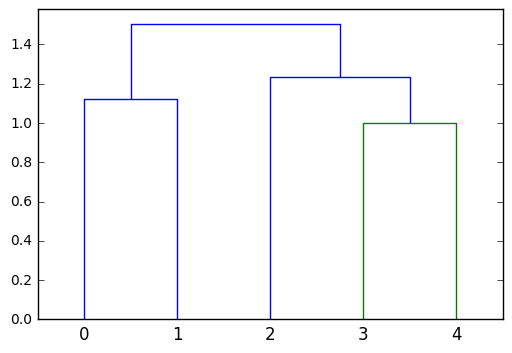

In [136]:
hierarchy.dendrogram(Z)
plt.show()

In [114]:
cm = np.array([1,2,3,4])
cm3 = np.array([4,3,2,1])
accuracy(cm)

0.5